<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Reference-Frame" data-toc-modified-id="Reference-Frame-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Reference Frame</a></span></li><li><span><a href="#Case-control-classification" data-toc-modified-id="Case-control-classification-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Case-control classification</a></span></li><li><span><a href="#Analyze-Effect-size" data-toc-modified-id="Analyze-Effect-size-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Analyze Effect size</a></span></li><li><span><a href="#Alpha-diversity" data-toc-modified-id="Alpha-diversity-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Alpha diversity</a></span></li></ul></div>

In [1]:
# This block is just for importing the necessary libraries.  
import os
from collections import defaultdict
# Numerical libraries
import pandas as pd
import numpy as np
import numpy.ma as ma

import biom
import arviz as az
from scipy.spatial.distance import euclidean
from gneiss.balances import sparse_balance_basis
# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib_venn import venn2, venn3
# custom utility and plotting functions
from util import (extract_differentials, select_features, 
                  get_genomic_data, collapse_transcripts, 
                  aggregate_pathways,
                  ranking, btest, log_pvalue, read_kegg_dict,
                  ilr_transform_differentials,
                  rename_clades, create_projection,
                  match_all_differentials)
from plot import (rankplot, networkplot, vectorplot)
import random

# directory paths
amp_directory = '../sfari/data/sra/Combined'
wgs_directory = '../sfari/data/sra_shotgun/Combined'
rna_directory = '../sfari/data/recount3'
kang_directory = '../sfari/data/sra/Kang2017'
sepp_directory = '../sfari/data/sra/Kang2017/deblur/sepp'
berding_directory = '../sfari/data/sra/Berding2020'

results_dir = '../results'
kegg_dir = f'{results_dir}/kegg'
hsa_dir = f'{results_dir}/hsa_kegg'
np.random.seed(0)
random.seed(0)
%matplotlib inline

pd.options.display.max_rows = 100 

Load biom tables and differentials

In [2]:
# load biom tables
amp_biom = biom.load_table(f'{kang_directory}/age_sex_match_week0_ogu.biom')
wgs_biom = biom.load_table(f'{wgs_directory}/ogus_table.biom')
amp_table = amp_biom.to_dataframe().T
wgs_table = wgs_biom.to_dataframe().T

# load metadata tables
amp_md = pd.read_table(f'{kang_directory}/combined_sample_metadata_0.txt', index_col=0)
wgs_md = pd.read_table(f'{wgs_directory}/sample_metadata.txt', index_col=0)

# load taxonomy
taxonomy = pd.read_table('~/databases/wol/taxonomy/ranks.tsv', index_col=0)
taxid = pd.read_table('~/databases/wol/taxonomy/taxid.map', header=None, dtype=str)
taxid.columns = ['GOTU', 'genome']
mapping = pd.merge(taxid, taxonomy, left_on='GOTU', right_index=True)
mapping = mapping.set_index('genome')

# load differentials
posterior_name = 'age_sex_matched_posterior'
amp_fname = f'{kang_directory}/week0_ogu/differentials-v8.nc'
wgs_fname = f'{wgs_directory}/{posterior_name}/ogus_differentials-v5.nc'
amp_diffs = extract_differentials(amp_fname)
wgs_diffs = extract_differentials(wgs_fname)

# Compute statistical tests for each data layer
# Here, we will only focus on the top 10% of the features
amp_stats = ranking(amp_diffs, reference_percentile=50, log_probs=True)
wgs_stats = ranking(wgs_diffs, reference_percentile=50) 

sort_col = 'mean'

Let's first visualize the heatmaps of the amplicon abundances

Text(0.5, 51.0, 'Microbes')

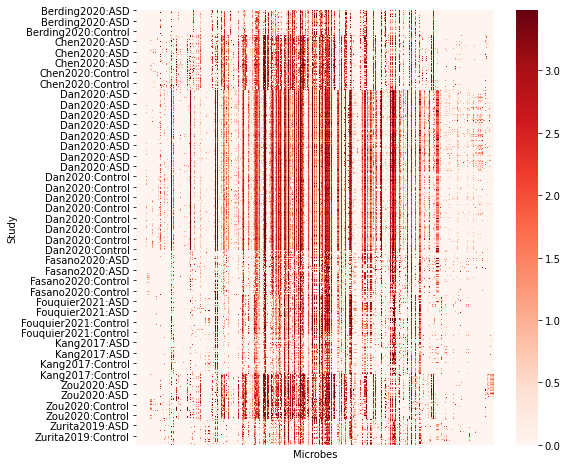

In [3]:
plt.figure(figsize=(8, 8))
amp_sorted_md = amp_md.sort_values(['Cohort', 'Status', 'Match_IDs'])
amp_sorted_table = amp_table.loc[amp_sorted_md.index]
amp_sorted_table['Study'] = amp_md.apply(lambda x: x['Cohort'] + ':' + x['Status'], axis=1)
amp_sorted_table = amp_sorted_table.set_index('Study')
amp_sorted_table = amp_sorted_table.loc[:, amp_stats.sort_values('mean').index]
sns.heatmap(np.log10(amp_sorted_table + 1), robust=True, cmap='Reds')
plt.xticks([])
plt.xlabel('Microbes')

# Reference Frame

Fit Gaussian mixture models to pick a better reference frame

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to

Text(0.5, 0, 'log fold change')

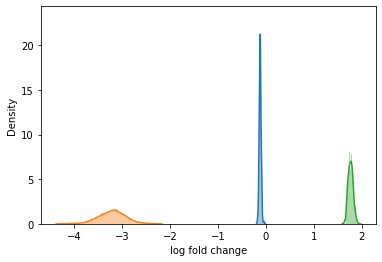

In [4]:
from util import solve, reorder, balance_thresholds
from plot import gaussian_mixture_plot
from sklearn.mixture import GaussianMixture

ast = amp_stats.copy()

# convert to clr coordinates
amp_clr_diffs = amp_diffs - amp_diffs.mean(axis=0)

gmod = GaussianMixture(n_components=3)
gmod.fit(X=amp_clr_diffs)

fig, ax = plt.subplots()
sns.distplot(gmod.means_[0], ax=ax)
sns.distplot(gmod.means_[1], ax=ax)
sns.distplot(gmod.means_[2], ax=ax)
plt.xlabel('log fold change')

In [5]:
from scipy.stats import multivariate_normal as mvn

# sorts by distribution, namely, left, middle and right
pdfs = np.vstack(
    [mvn.pdf(amp_clr_diffs.values, mean=gmod.means_[i], cov=gmod.covariances_[i])
     for i in np.argsort(gmod.means_.mean(axis=1))]
).T
cluster_labels = np.argmax(pdfs, axis=1)

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/scipy/stats/_multivariate.py:528: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, mean, psd.U, psd.log_pdet, psd.rank))


In [6]:
gm = np.sort(gmod.means_.mean(axis=1))

reference_frame = gm[1]  # set ANCOM-BC like delta

# Compute statistical tests for each data layer
# Here, we will only focus on the top 10% of the features
amp_stats = ranking(amp_diffs, reference_frame=reference_frame, log_probs=True)
wgs_stats = ranking(wgs_diffs, reference_percentile=50)  # TODO

amp_stats['cluster_id'] = cluster_labels

def cluster_f(x):
    if x == 0:
        return 'denom'
    if x == 1:
        return 'neutral'
    if x == 2:
        return 'num'
    return None

amp_stats['cluster_name'] = amp_stats['cluster_id'].apply(cluster_f) 

sort_col = 'mean'

# Remove taxa with few counts
idx = (amp_table > 0).sum(axis=0) > 3
amp_table = amp_table.loc[:, idx]
amp_stats = amp_stats.loc[amp_table.columns]

# Case-control classification

Compute clr transform on tables and sort by the ranking

In [7]:
amp_stats = amp_stats.sort_values(sort_col)
wgs_stats = wgs_stats.sort_values(sort_col)

amp_table = amp_table.loc[:, amp_stats.index]
wgs_table = wgs_table.loc[:, wgs_stats.index]

amp_ma = ma.array(amp_table.values, mask=amp_table.values == 0)
wgs_ma = ma.array(wgs_table.values, mask=wgs_table.values == 0)

amp_log = ma.log(amp_ma)
wgs_log = ma.log(wgs_ma)

amp_clr = amp_log - amp_log.mean(axis=1).reshape(-1, 1)
wgs_clr = wgs_log - wgs_log.mean(axis=1).reshape(-1, 1)

amp_clr = pd.DataFrame(amp_clr, index=amp_table.index, columns=amp_table.columns).fillna(0)
wgs_clr = pd.DataFrame(wgs_clr, index=wgs_table.index, columns=wgs_table.columns).fillna(0)

# perform double centering to see if batch effects become more obvious
#amp_clr = amp_clr - amp_clr.mean(axis=0)
#wgs_clr = wgs_clr - wgs_clr.mean(axis=0)

#amp_clr = np.ma.log(amp_table.values)
#amp_clr = amp_clr - amp_clr.mean(axis=1).values.reshape(-1, 1)

#wgs_clr = np.ma.log(wgs_table.values)
#wgs_clr = wgs_clr - wgs_clr.mean(axis=1).values.reshape(-1, 1)

Compute differences between asd subjects and controls for each matching

In [8]:
amp_clr = pd.merge(amp_md[['Match_IDs', 'Status']], amp_clr, left_index=True, right_index=True)
wgs_clr = pd.merge(wgs_md[['Match_IDs', 'Status']], wgs_clr, left_index=True, right_index=True)

amp_clr = amp_clr.sort_values(by=['Status', 'Match_IDs'])
wgs_clr = wgs_clr.sort_values(by=['Status', 'Match_IDs'])

amp_asd = amp_clr.loc[amp_clr['Status'] == 'ASD']
amp_con = amp_clr.loc[amp_clr['Status'] == 'Control']

wgs_asd = wgs_clr.loc[wgs_clr['Status'] == 'ASD']
wgs_con = wgs_clr.loc[wgs_clr['Status'] == 'Control']

amp_asd_con = pd.DataFrame(
    amp_asd.iloc[:, 2:].values - amp_con.iloc[:, 2:].values,
    index=amp_asd['Match_IDs'], columns=amp_asd.columns[2:])
wgs_asd_con = pd.DataFrame(
    wgs_asd.iloc[:, 2:].values - wgs_con.iloc[:, 2:].values,
    index=wgs_asd['Match_IDs'], columns=wgs_asd.columns[2:])

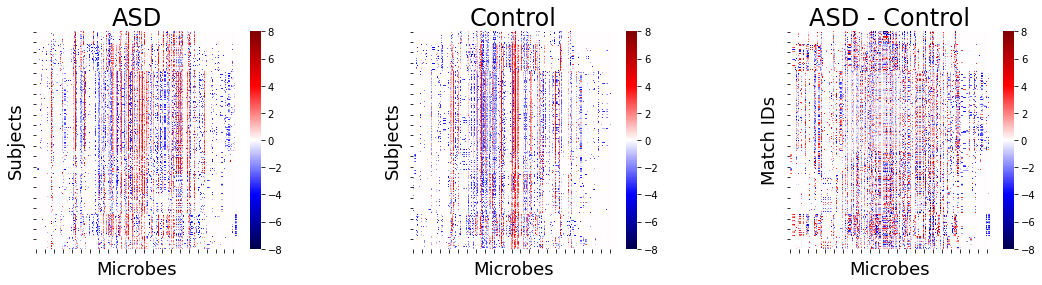

In [9]:
import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

fig, ax = plt.subplots(1, 3, figsize=(18, 4))
sns.heatmap(amp_asd.iloc[:, 2:].values, cmap='seismic', 
            norm=MidpointNormalize(midpoint=0., vmin=-8, vmax=8),
            robust=False, ax=ax[0], cbar=True)
sns.heatmap(amp_con.iloc[:, 2:].values, cmap='seismic', 
            norm=MidpointNormalize(midpoint=0., vmin=-8, vmax=8),
            robust=False, ax=ax[1], cbar=True)
sns.heatmap(amp_asd_con, cmap='seismic', 
            norm=MidpointNormalize(midpoint=0., vmin=-8, vmax=8),
            robust=False, ax=ax[2])

titles = ['ASD', 'Control', 'ASD - Control']
for i, a in enumerate(ax):
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.set_xlabel('Microbes', fontsize=18)
    a.set_ylabel('Subjects', fontsize=18)
    a.set_title(titles[i], fontsize=24)

ax[2].set_ylabel('Match IDs', fontsize=18)

plt.subplots_adjust(wspace=0.5)
#plt.tight_layout()

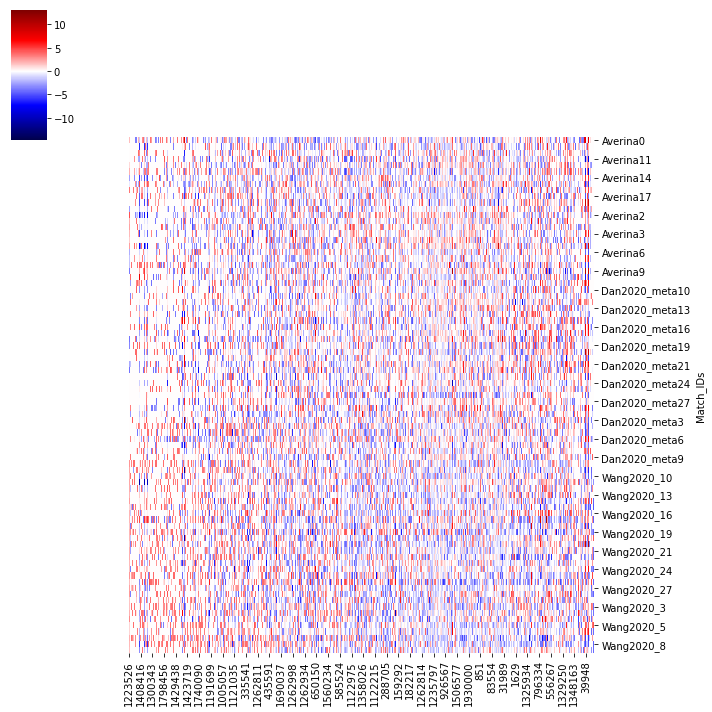

In [10]:
sns.clustermap(wgs_asd_con, cmap='seismic', figsize=(10, 10), norm=MidpointNormalize(midpoint=0.),
               row_cluster=False, col_cluster=False, robust=True)

Let's now perform classification.  We will select the top ASD associated microbes and the top control associated microbes, then compute their log-ratio, namely

$\textrm{log-ratio} = \log \frac{g(x_{asd})}{g(x_{control})}$

where $x_{asd}$ denotes the abundances of the top 200 ASD associated microbes and 
$x_{control}$ denotes the abundances of the top 200 control associated microbes.

We compute this log-ratio for each sample, and then we compute the difference between  matched ASD and Control samples.

In [11]:
def balance_classifier(table, md, stats, t=100, b=100):
    pairs = {}
    for n, pair in md.groupby('Match_IDs'):
        p = pair.sort_values('Status')
        asd, con = p.index[0], p.index[1]
        top = stats.tail(t).index
        bot = stats.head(b).index
        asd_lr = np.log(table.loc[asd, top] + 1).mean() - np.log(table.loc[asd, bot] + 1).mean()
        con_lr = np.log(table.loc[con, top] + 1).mean() - np.log(table.loc[con, bot] + 1).mean()
        pairs[n] = asd_lr - con_lr
    return pd.Series(pairs)

We are computing log-ratios per sample and plotting their distribution.

As we can see these log-ratios are heavily weighted towards the controls,
suggesting that these log-ratios form a *very* good classifier (i.e. there is no overlap with zero).

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


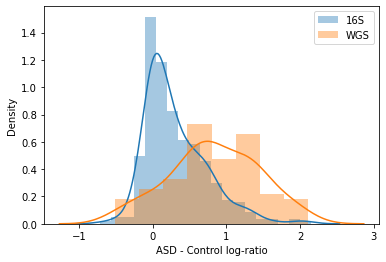

In [12]:
# use Gaussian mixture models way above to choose numerator / denominator
rs = amp_stats['cluster_name'].value_counts()
r = rs['denom']
s = rs['num']

amp_lrs = balance_classifier(amp_table, amp_md, amp_stats.sort_values(['cluster_name', 'mean'])['mean'], t=r, b=s)
wgs_lrs = balance_classifier(wgs_table, wgs_md, wgs_stats['mean'], t=200, b=200)

sns.distplot(amp_lrs, label='16S')
sns.distplot(wgs_lrs, label='WGS')
plt.xlabel('ASD - Control log-ratio')
plt.legend()

In [13]:
np.mean(amp_lrs > 0)

0.7745358090185677

In [14]:
np.mean(wgs_lrs > 0)

0.891566265060241

Let's now overlay these results over the heatmaps

In [15]:
import matplotlib.colors as colors
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

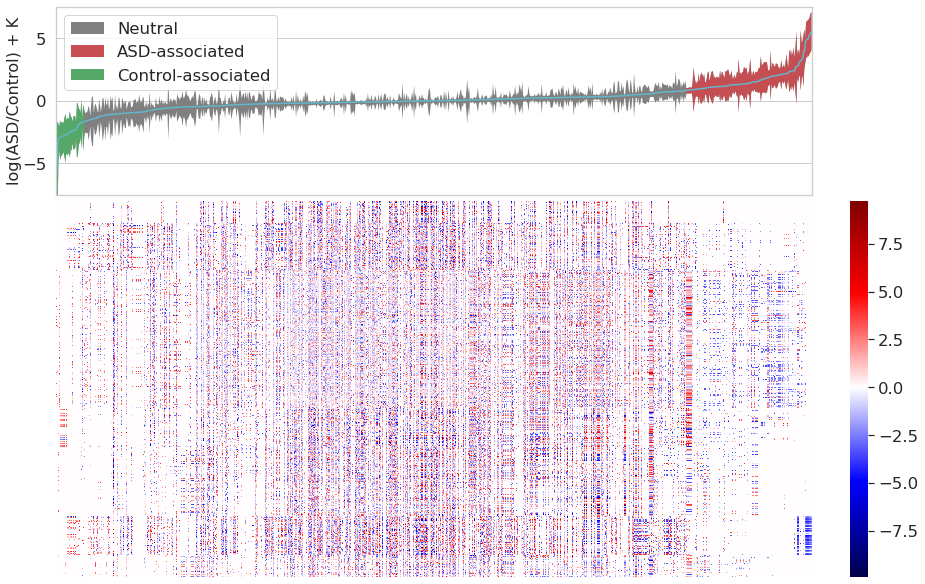

In [16]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

taxa_names = mapping['species']

fig = plt.figure(constrained_layout=True, figsize=(18, 8))
gs = fig.add_gridspec(3, 3)
ax1 = fig.add_subplot(gs[1:, :2])
#ax2 = fig.add_subplot(gs[1:, 2])
ax3 = fig.add_subplot(gs[0, :2])

amp_stats.sort_values('mean')
X = amp_asd_con.loc[:, amp_stats.index]
X.columns = list(map(lambda x: np.unique(taxa_names.loc[x])[0], X.columns))
g = sns.heatmap(X, 
                robust=True, cbar=True,
                cmap='seismic', ax=ax1, 
                norm=MidpointNormalize(midpoint=0.))
ax1.set_yticks([])
ax1.set_xticks([])
ax1.set_ylabel('')
#ax = ax2
#sns.regplot(amp_lrs.values, np.arange(len(amp_lrs)), ax=ax, fit_reg=False)
#ax.set_yticks([])
#ax.set_ylim([0, len(amp_lrs)])
#ax.set_xlim([-3, 3])
#ax.vlines(0, 0, len(amp_lrs), 'r')
#ax.set_xlabel('ASD:Control Balance', 
#               fontsize=16)


ax = ax3
## rank plot
lr = amp_stats
sort_col = 'mean'
lr = lr.sort_values('effect_size')
threshold = 1e-3 / len(lr)
idx = np.arange(len(lr))
lr = lr.sort_values(sort_col)
cmap = matplotlib.cm.get_cmap('seismic')
lr['index'] = idx
ax.fill_between(lr['index'], lr['5%'], lr['95%'], fc='#808080', label='Neutral', lw=0)
i = lr['cluster_name'] == 'num'
ax.fill_between(lr.loc[i, 'index'], lr.loc[i, '5%'], lr.loc[i, '95%'], fc='r', lw=0,
                label='ASD-associated')

i = lr['cluster_name'] == 'denom'
ax.fill_between(lr.loc[i, 'index'], lr.loc[i, '5%'], lr.loc[i, '95%'], fc='g', lw=0,
                label='Control-associated')    
ax.plot(lr['index'], lr['mean'], c='c')

ax.set_ylabel('log(ASD/Control) + K', fontsize=16, rotation=90, labelpad=0)
ax.set_xticks([])
ax.set_xlim([0, len(amp_stats)])
ax.set_ylim(-7.5, 7.5)
ax.legend(loc=2)
#plt.tight_layout()

In [17]:
amp_stats['cluster_name'].value_counts()

neutral    678
num        142
denom       32
Name: cluster_name, dtype: int64

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


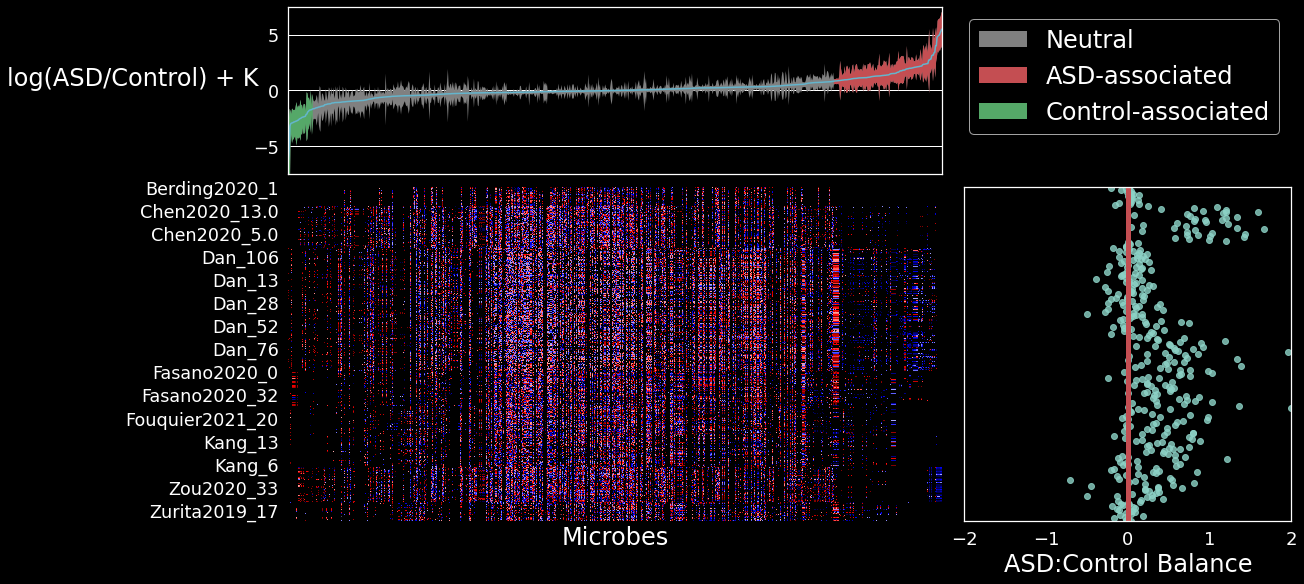

In [18]:
sns.set(font_scale=1.6)
sns.set_style('whitegrid')
with plt.style.context('dark_background'):

    taxa_names = mapping['species']

    fig = plt.figure(constrained_layout=True, figsize=(18, 8))
    gs = fig.add_gridspec(3, 3)
    ax1 = fig.add_subplot(gs[1:, :2])
    ax2 = fig.add_subplot(gs[1:, 2])
    ax3 = fig.add_subplot(gs[0, :2])
    ax4 = fig.add_subplot(gs[0, 2])

    amp_stats.sort_values('mean')
    X = amp_asd_con.loc[:, amp_stats.index]
    X.columns = list(map(lambda x: np.unique(taxa_names.loc[x])[0], X.columns))
    k = 20
    colors =  [(plt.cm.seismic(i)) for i in range(1, 128 - k )]
    colors += [(0, 0, 0)] * 2 * k + [(plt.cm.seismic(i)) for i in range(128 + k, 256)]
    new_map = matplotlib.colors.LinearSegmentedColormap.from_list('new_map', colors, N = 256)

    g = sns.heatmap(X, 
                    robust=True, cbar=False,
                    #cmap='seismic', 
                    #cmap='twilight',
                    cmap=new_map,
                    ax=ax1, 
                    #norm=MidpointNormalize(midpoint=0.)
                   )
    ax1.set_xticks([])
    
    ax1.set_xlabel('Microbes', fontsize=24)
    ax1.set_ylabel('', fontsize=24)
    # classification plot
    ax = ax2
    sns.regplot(amp_lrs.values, np.arange(len(amp_lrs)), ax=ax, fit_reg=False)

    ax.set_yticks([])
    ax.set_ylim([0, len(amp_lrs)])
    ax.set_xlim([-2, 2])
    ax.tick_params(labelsize=18, axis='x')
    ax.vlines(0, 0, len(amp_lrs), 'r', lw=5)
    ax.set_xlabel('ASD:Control Balance', 
                   fontsize=24)
    #ax.axis('off')
    ax.grid(False)
    
    ax = ax3
    ## rank plot
    lr = amp_stats
    sort_col = 'mean'
    lr = lr.sort_values('effect_size')
    threshold = 1e-3 / len(lr)
    idx = np.arange(len(lr))
    lr = lr.sort_values(sort_col)
    cmap = matplotlib.cm.get_cmap('seismic')
    lr['index'] = idx
    ax.fill_between(lr['index'], lr['5%'], lr['95%'], fc='#808080', label='Neutral', lw=0)
    i = lr['cluster_name'] == 'num'
    ax.fill_between(lr.loc[i, 'index'], lr.loc[i, '5%'], lr.loc[i, '95%'], fc='r', lw=0,
                    label='ASD-associated')
    
    i = lr['cluster_name'] == 'denom'
    ax.fill_between(lr.loc[i, 'index'], lr.loc[i, '5%'], lr.loc[i, '95%'], fc='g', lw=0,
                    label='Control-associated')    
    ax.plot(lr['index'], lr['mean'], c='c')
    
    ax.set_ylabel('log(ASD/Control) + K', fontsize=24, rotation=0, labelpad=120)
    ax.set_xticks([])
    ax.set_xlim([0, len(amp_stats)])
    ax.set_ylim([-7.5, 7.5])
    
    h, l = ax.get_legend_handles_labels() # get labels and handles from ax3
    ax4.grid(False)
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax4.axis('off')
    ax4.legend(h, l, fontsize=24)
    #plt.tight_layout()

In [19]:
amp_stats.to_csv('../results/amplicon_differentials.csv')

Let's do the same thing with the WGS dataset

Let's do another sanity check, rather than computing log-ratios for each pair, let's do it for each sample and directly look at those results.

In [20]:
def balance_per_sample(table, md, stats, t=100, b=100):
    pairs = {}
    for i in table.index:
        top = stats.tail(t).index
        bot = stats.head(b).index
        lr = np.log(table.loc[i, top] + 1).mean() - np.log(table.loc[i, bot] + 1).mean()
        pairs[i] = lr
    return pd.Series(pairs)

In [21]:
rs = amp_stats['cluster_name'].value_counts()
r = rs['denom']
s = rs['num']

amp_lrs = balance_per_sample(amp_table, amp_md, amp_stats.sort_values(['cluster_name', 'mean'])['mean'], 
                             t=r, b=s)
wgs_lrs = balance_per_sample(wgs_table, wgs_md, wgs_stats['mean'], t=200, b=200)


amp_md_ = pd.merge(amp_md, pd.DataFrame({'log_ratio': amp_lrs}), left_index=True, right_index=True)
wgs_md_ = pd.merge(wgs_md, pd.DataFrame({'log_ratio': wgs_lrs}), left_index=True, right_index=True)

amp_md_ = amp_md_.sort_values('log_ratio')
amp_md_ = amp_md_.sort_values('Cohort')
amp_md_ = amp_md_.sort_values('Status')

wgs_md_ = wgs_md_.sort_values('log_ratio')
wgs_md_ = wgs_md_.sort_values('Cohort')
wgs_md_ = wgs_md_.sort_values('Status')

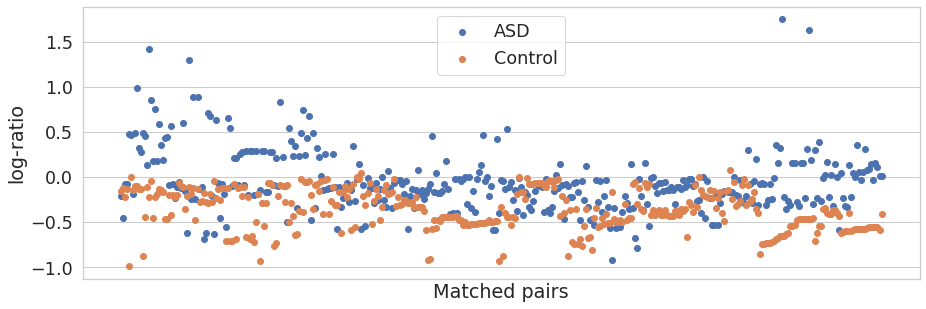

In [22]:
fig, ax = plt.subplots(figsize=(15, 5))
idx = np.arange(377)
ax.scatter(idx, amp_md_.loc[amp_md_['Status'] == 'ASD', 'log_ratio'], label='ASD')
ax.scatter(idx, amp_md_.loc[amp_md_['Status'] == 'Control', 'log_ratio'], label='Control')
ax.set_xticks([])
ax.set_xlabel('Matched pairs')
ax.set_ylabel('log-ratio')
ax.legend()

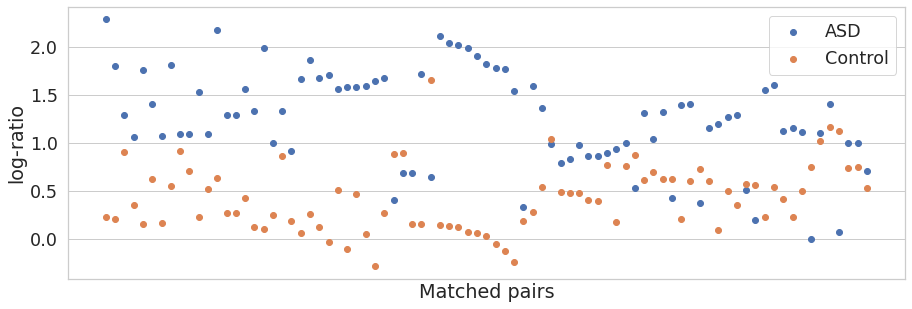

In [23]:
fig, ax = plt.subplots(figsize=(15, 5))
idx = np.arange(83)
ax.scatter(idx, wgs_md_.loc[wgs_md_['Status'] == 'ASD', 'log_ratio'], label='ASD')
ax.scatter(idx, wgs_md_.loc[wgs_md_['Status'] == 'Control', 'log_ratio'], label='Control')
ax.set_xticks([])
ax.set_xlabel('Matched pairs')
ax.set_ylabel('log-ratio')
ax.legend()

In [24]:
ast = pd.merge(amp_stats, mapping, left_index=True, right_index=True)
ast = ast[~ast.index.duplicated(keep='first')]  # drop duplicates due to taxonomy
ast.to_csv('../results/amp-crossectional.csv')

ast.to_csv('../results/supplemental_tables/Table_S1.csv')

wst = pd.merge(wgs_stats, mapping, left_index=True, right_index=True)
wst = wst[~wst.index.duplicated(keep='first')]  # drop duplicates due to taxonomy
wst.to_csv('../results/wgs-crossectional.csv')

wst.to_csv('../results/supplemental_tables/Table_S2.csv')

In [25]:
idx = ast.species.apply(lambda x: 'copri' in x)
ast.loc[idx]

,mean,std,5%,50%,95%,counts_bot,counts_top,prob_top,prob_bot,prob_lr,...,cluster_id,cluster_name,GOTU,kingdom,phylum,class,order,family,genus,species
537011,-1.078881,0.181869,-1.353329,-1.096786,-0.772869,0.0,0.0,0.000782,0.000782,0.0,...,1,neutral,G000157935,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella,Prevotella copri


Save study counts

In [26]:
amp_df = pd.merge((amp_table > 0).astype(np.int64), amp_md['Cohort'], left_index=True, right_index=True)
amp_df = amp_df.groupby('Cohort').sum().T
amp_df['num_studies'] = (amp_df > 0).sum(axis=1)
amp_df['num_samples'] = (amp_df).sum(axis=1)
amp_df = pd.merge(amp_stats, amp_df, left_index=True, right_index=True)
#t=161
#b=67
ast = pd.merge(amp_df, mapping, left_index=True, right_index=True)
ast = ast.sort_values(sort_col)
#ast = pd.concat((ast.head(b), ast.tail(t)), axis=0)
ast.to_csv('../results/amp-crossectional-studies.csv')

In [27]:
amp_md['Cohort'].value_counts()

Dan2020         278
Chen2020         94
Zou2020          78
Fasano2020       78
Kang2017         70
Fouquier2021     68
Zurita2019       44
Berding2020      44
Name: Cohort, dtype: int64

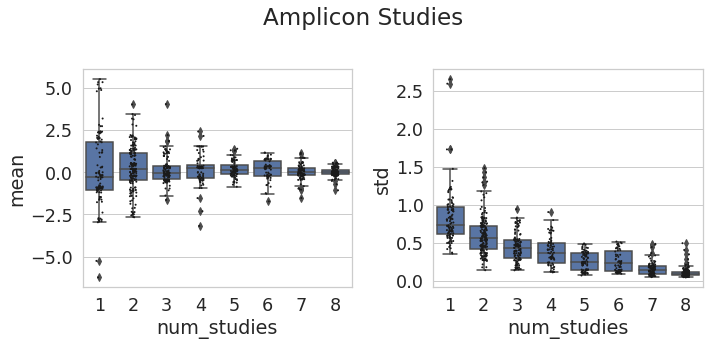

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.boxplot(x='num_studies', y='mean', data=ast, ax=ax[0], color='b')
sns.stripplot(x='num_studies', y='mean', data=ast, ax=ax[0], color='k', s=2)

#ax[0].scatter(ast['num_studies'], ast['mean'], s=1)
ax[0].set_ylabel('mean')
ax[0].set_xlabel('num_studies')

sns.boxplot(x='num_studies', y='std', data=ast, ax=ax[1], color='b')
sns.stripplot(x='num_studies', y='std', data=ast, ax=ax[1], color='k', s=2)

#ax[1].scatter(ast['num_studies'], ast['std'], s=1)
ax[1].set_ylabel('std')

ax[1].set_xlabel('num_studies')
plt.suptitle('Amplicon Studies')
plt.tight_layout()

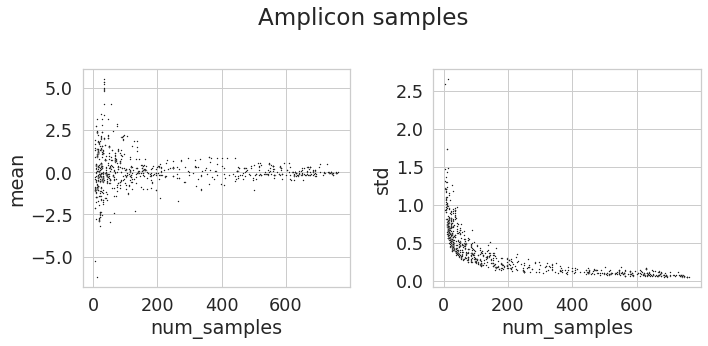

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(x='num_samples', y='mean', data=ast, ax=ax[0], color='k', s=2)

#ax[0].scatter(ast['num_samples'], ast['mean'], s=1)
ax[0].set_ylabel('mean')
ax[0].set_xlabel('num_samples')

sns.scatterplot(x='num_samples', y='std', data=ast, ax=ax[1], color='k', s=2)

#ax[1].scatter(ast['num_samples'], ast['std'], s=1)
ax[1].set_ylabel('std')

ax[1].set_xlabel('num_samples')
plt.suptitle('Amplicon samples')
plt.tight_layout()

Create plot as a volcano plot, but only keep taxa where the means are 2 standard deviations away from zero.

(-8.0, 7.0)

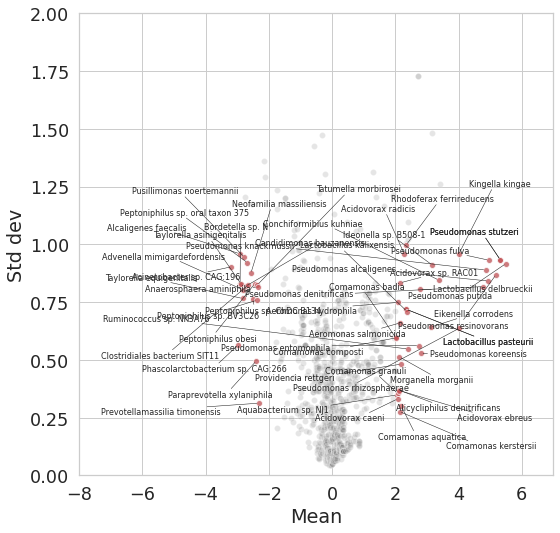

In [30]:
from plot import plot_volcano
fig, ax = plt.subplots(figsize=(8.5, 8.5))

def filter_func(x):
    m, s = x
    return (np.abs(m) - 2 * s) > 0 and np.abs(m) > 2 and s < 1

plot_volcano(ast, 'mean', 'std', name_col='species', filter_f=filter_func, adjust=True, ax=ax,
             force_text=(0.25, 0.5), force_points=(0.5, 0.7))

ax.set_ylim([0, 2])
ax.set_xlim([-8, 7])

In [31]:
ast = ast[~ast.index.duplicated(keep='first')]  # drop duplicates due to taxonomy

In [32]:
ast

,mean,std,5%,50%,95%,counts_bot,counts_top,prob_top,prob_bot,prob_lr,...,num_studies,num_samples,GOTU,kingdom,phylum,class,order,family,genus,species
1444768,-6.231882,2.652388,-10.983252,-5.976741,-2.536484,36.0,0.0,0.000782,0.028951,-3.610918,...,1,12,G000710465,Bacteria,Actinobacteria,Actinobacteria,Streptomycetales,Streptomycetaceae,Kitasatospora,Kitasatospora sp. MBT63
626522,-5.255982,2.592726,-9.873123,-5.004493,-1.603324,24.0,0.0,0.000782,0.019562,-3.218876,...,1,5,G000159995,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Prevotellaceae,Alloprevotella,Alloprevotella tannerae
1262690,-3.184505,0.902578,-4.828283,-3.138014,-1.784959,0.0,0.0,0.000782,0.000782,0.000000,...,4,21,G000433235,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Moraxellaceae,Acinetobacter,Acinetobacter sp. CAG:196
1262915,-2.970171,0.563890,-3.843714,-2.945440,-2.080393,0.0,0.0,0.000782,0.000782,0.000000,...,1,54,G000436095,Bacteria,Firmicutes,Negativicutes,Acidaminococcales,Acidaminococcaceae,Phascolarctobacterium,Phascolarctobacterium sp. CAG:266
511,-2.923046,0.959184,-4.672983,-2.804502,-1.576418,0.0,0.0,0.000782,0.000782,0.000000,...,1,17,G000967305,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Alcaligenaceae,Alcaligenes,Alcaligenes faecalis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43263,4.937882,0.840991,3.719859,4.843160,6.440029,0.0,36.0,0.028951,0.000782,3.610918,...,1,35,G001597285,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,Pseudomonas alcaligenes
743720,4.956444,0.931120,3.560455,4.885639,6.533717,0.0,45.0,0.035994,0.000782,3.828641,...,1,35,G000213805,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,Pseudomonas fulva
1245471,5.183621,0.867959,3.843577,5.151263,6.679887,0.0,48.0,0.038341,0.000782,3.891820,...,1,35,G000412695,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,Pseudomonas resinovorans
316,5.318296,0.933140,3.898020,5.263604,6.999767,0.0,85.0,0.067293,0.000782,4.454347,...,1,35,G000590475,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,Pseudomonas stutzeri


In [33]:
wgs_df = pd.merge((wgs_table > 0).astype(np.int64), wgs_md['Cohort'], left_index=True, right_index=True)
wgs_df = wgs_df.groupby('Cohort').sum().T
wgs_df['num_studies'] = (wgs_df > 0).sum(axis=1)
wgs_df['num_samples'] = (wgs_df).sum(axis=1)

wgs_df = pd.merge(wgs_stats, wgs_df, left_index=True, right_index=True)
#t=161
#b=67
wst = pd.merge(wgs_df, mapping, left_index=True, right_index=True)
wst = wst.sort_values(sort_col)
#wst = pd.concat((wst.head(b), wst.tail(t)), axis=0)
wst.to_csv('../results/wgs-crossectional-studies.csv')

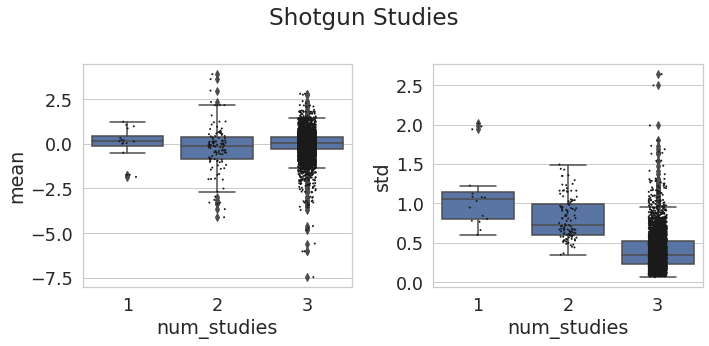

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.boxplot(x='num_studies', y='mean', data=wst, ax=ax[0], color='b')
sns.stripplot(x='num_studies', y='mean', data=wst, ax=ax[0], color='k', s=2)

ax[0].set_ylabel('mean')
ax[0].set_xlabel('num_studies')

sns.boxplot(x='num_studies', y='std', data=wst, ax=ax[1], color='b')
sns.stripplot(x='num_studies', y='std', data=wst, ax=ax[1], color='k', s=2)

ax[1].set_ylabel('std')

ax[1].set_xlabel('num_studies')
plt.suptitle('Shotgun Studies')
plt.tight_layout()

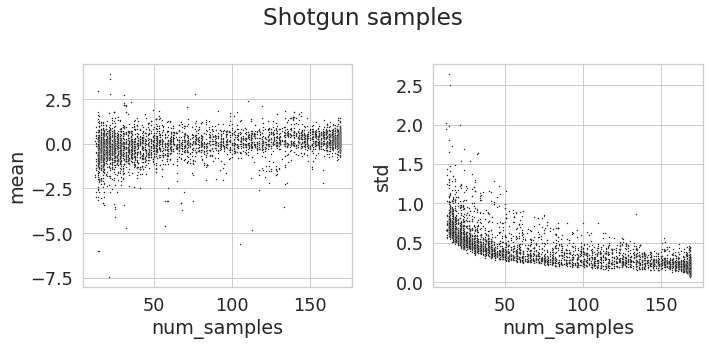

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(x='num_samples', y='mean', data=wst, ax=ax[0], color='k', s=2)

#ax[0].scatter(wst['num_samples'], wst['mean'], s=1)
ax[0].set_ylabel('mean')
ax[0].set_xlabel('num_samples')

sns.scatterplot(x='num_samples', y='std', data=wst, ax=ax[1], color='k', s=2)

#ax[1].scatter(wst['num_samples'], wst['std'], s=1)
ax[1].set_ylabel('std')

ax[1].set_xlabel('num_samples')
plt.suptitle('Shotgun samples')
plt.tight_layout()

(-9.0, 6.0)

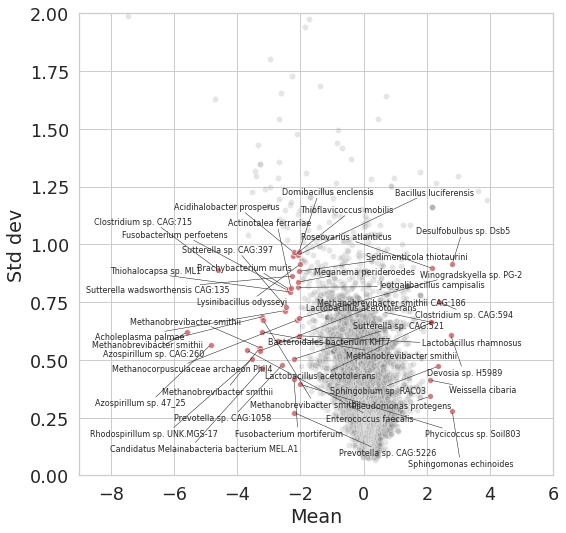

In [36]:
fig, ax = plt.subplots(figsize=(8.5, 8.5))

def filter_func(x):
    m, s = x
    return (np.abs(m) - 2 * s) > 0 and np.abs(m) > 2 and s < 1

plot_volcano(wst, 'mean', 'std', name_col='species', filter_f=filter_func, adjust=True, ax=ax,
             force_text=(0.25, 0.5), force_points=(0.5, 0.7))

ax.set_ylim([0, 2])
ax.set_xlim([-9, 6])

In [37]:
def filter_f2(x):
    m, s = x['mean'], x['std']
    if x['num_studies'] < 3:
        return False
    else:
        return (np.abs(m) - 2 * s) > 0 and np.abs(m) > 1 and s < 1


idx = wst.apply(filter_f2, axis=1)
subwst = wst.loc[idx]
subwst.sort_values('tstat').to_csv('../results/wgs_subset.csv')
subwst.sort_values('tstat')

,mean,std,5%,50%,95%,effect_size,effect_std,tstat,pvalue,Averina2020,...,num_studies,num_samples,GOTU,kingdom,phylum,class,order,family,genus,species
1262706,-5.582045,0.620157,-6.685980,-5.573734,-4.639692,-14.514100,2.600140,-182.917333,0.000000e+00,33,...,3,105,G000436195,Bacteria,Proteobacteria,Alphaproteobacteria,Rhodospirillales,Rhodospirillaceae,Azospirillum,Azospirillum sp. CAG:260
1896971,-4.828242,0.566043,-5.703273,-4.838683,-3.944207,-15.069211,3.121056,-173.770246,0.000000e+00,36,...,3,113,G001917125,Bacteria,Proteobacteria,Alphaproteobacteria,Rhodospirillales,Rhodospirillaceae,Azospirillum,Azospirillum sp. 47_25
1262930,-2.196355,0.271357,-2.647507,-2.186878,-1.793197,-29.827793,13.580590,-168.500108,0.000000e+00,40,...,3,158,G000434455,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella,Prevotella sp. CAG:5226
1638782,-3.544946,0.502180,-4.314681,-3.569385,-2.691316,-14.056924,3.965342,-144.759711,0.000000e+00,41,...,3,133,G000980655,Bacteria,Proteobacteria,Alphaproteobacteria,Rhodospirillales,Rhodospirillaceae,Rhodospirillum,Rhodospirillum sp. UNK.MGS-17
1899017,-3.215117,0.462474,-3.924332,-3.202603,-2.487353,-15.032190,4.675472,-142.924577,0.000000e+00,28,...,3,75,G001765415,Bacteria,NaN,NaN,NaN,NaN,NaN,Candidatus Melainabacteria bacterium MEL.A1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68570,1.099768,0.191962,0.791005,1.105942,1.403463,29.845082,27.137609,105.223235,4.102063e-293,36,...,3,161,G000695235,Bacteria,Actinobacteria,Actinobacteria,Streptomycetales,Streptomycetaceae,Streptomyces,Streptomyces albulus
68570,1.099768,0.191962,0.791005,1.105942,1.403463,29.845082,27.137609,105.223235,4.102063e-293,36,...,3,161,G001646665,Bacteria,Actinobacteria,Actinobacteria,Streptomycetales,Streptomycetaceae,Streptomyces,Streptomyces albulus
155892,1.689501,0.282700,1.225222,1.692650,2.166255,21.140147,12.512661,113.171228,2.530819e-305,1,...,3,44,G001449105,Bacteria,Proteobacteria,Alphaproteobacteria,Caulobacterales,Caulobacteraceae,Caulobacter,Caulobacter vibrioides
1124983,2.084496,0.341096,1.506617,2.118310,2.645748,17.916255,8.595004,116.956352,7.393786e-311,11,...,3,71,G000397205,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,Pseudomonas protegens


In [38]:
ast.loc[ast['family'] == 'Neisseriaceae']

,mean,std,5%,50%,95%,counts_bot,counts_top,prob_top,prob_bot,prob_lr,...,num_studies,num_samples,GOTU,kingdom,phylum,class,order,family,genus,species
122586,-0.289084,0.280387,-0.741886,-0.305036,0.177796,0.0,0.0,0.000782,0.000782,0.000000,...,3,101,G000008805,Bacteria,Proteobacteria,Betaproteobacteria,Neisseriales,Neisseriaceae,Neisseria,Neisseria meningitidis
489653,-0.239441,0.227324,-0.617491,-0.229346,0.137392,0.0,0.0,0.000782,0.000782,0.000000,...,3,101,G000196295,Bacteria,Proteobacteria,Betaproteobacteria,Neisseriales,Neisseriaceae,Neisseria,Neisseria lactamica
242231,-0.206729,0.262129,-0.626100,-0.220862,0.243018,0.0,0.0,0.000782,0.000782,0.000000,...,3,101,G000006845,Bacteria,Proteobacteria,Betaproteobacteria,Neisseriales,Neisseriaceae,Neisseria,Neisseria gonorrhoeae
888741,-0.035407,0.224691,-0.400485,-0.024689,0.335743,0.0,0.0,0.000782,0.000782,0.000000,...,3,106,G000190695,Bacteria,Proteobacteria,Betaproteobacteria,Neisseriales,Neisseriaceae,Kingella,Kingella denitrificans
435832,0.029874,0.204000,-0.294607,0.035891,0.352184,0.0,0.0,0.000782,0.000782,0.000000,...,3,114,G000186165,Bacteria,Proteobacteria,Betaproteobacteria,Neisseriales,Neisseriaceae,Neisseria,Neisseria mucosa
888742,0.279819,0.491792,-0.485230,0.258504,1.127590,0.0,0.0,0.000782,0.000782,0.000000,...,1,15,G000194925,Bacteria,Proteobacteria,Betaproteobacteria,Neisseriales,Neisseriaceae,Neisseria,Neisseria bacilliformis
1696094,0.319117,0.535235,-0.572729,0.348713,1.142653,0.0,0.0,0.000782,0.000782,0.000000,...,1,15,G001308005,Bacteria,Proteobacteria,Betaproteobacteria,Neisseriales,Neisseriaceae,Neisseria,Neisseria sp. 74A18
1056807,0.724676,0.246021,0.326860,0.714964,1.146361,0.0,0.0,0.000782,0.000782,0.000000,...,6,229,G001063255,Bacteria,Proteobacteria,Betaproteobacteria,Neisseriales,Neisseriaceae,Morococcus,Morococcus cerebrosus
28091,1.269304,0.324360,0.725912,1.275921,1.784461,0.0,0.0,0.000782,0.000782,0.000000,...,3,135,G900086555,Bacteria,Proteobacteria,Betaproteobacteria,Neisseriales,Neisseriaceae,Neisseria,Neisseria weaveri
546262,1.483458,0.316488,0.963478,1.491570,1.977743,0.0,0.0,0.000782,0.000782,0.000000,...,3,135,G000173895,Bacteria,Proteobacteria,Betaproteobacteria,Neisseriales,Neisseriaceae,Neisseria,Neisseria cinerea


In [39]:
wst.loc[wst['family'] == 'Neisseriaceae']

,mean,std,5%,50%,95%,effect_size,effect_std,tstat,pvalue,Averina2020,...,num_studies,num_samples,GOTU,kingdom,phylum,class,order,family,genus,species
1121351,-0.611639,0.833601,-2.089465,-0.550698,0.723958,-0.880194,1.439074,-16.829796,2.060273e-48,4,...,3,18,G000428785,Bacteria,Proteobacteria,Betaproteobacteria,Neisseriales,Neisseriaceae,Conchiformibius,Conchiformibius kuhniae
857265,-0.487488,0.733419,-1.886685,-0.393644,0.535166,-0.906274,1.859068,-15.743127,8.852622e-44,8,...,3,23,G001294205,Bacteria,Proteobacteria,Betaproteobacteria,Neisseriales,Neisseriaceae,Amantichitinum,Amantichitinum ursilacus
1120980,-0.351406,0.662750,-1.466510,-0.314203,0.670135,-0.800036,2.276675,-13.315232,1.000314e-33,5,...,3,21,G000745955,Bacteria,Proteobacteria,Betaproteobacteria,Neisseriales,Neisseriaceae,Alysiella,Alysiella crassa
1196094,-0.088275,0.430198,-0.823690,-0.059898,0.530129,-0.476984,5.403363,-8.280055,1.877789e-15,20,...,3,100,G000600005,Bacteria,Proteobacteria,Betaproteobacteria,Neisseriales,Neisseriaceae,Snodgrassella,Snodgrassella alvi
1349758,-0.023701,0.396570,-0.644885,-0.021669,0.637955,-0.150708,6.358597,-5.725556,2.030049e-08,15,...,3,49,G001592185,Bacteria,Proteobacteria,Betaproteobacteria,Neisseriales,Neisseriaceae,Bergeriella,Bergeriella denitrificans
504,0.016520,0.221107,-0.352374,0.015793,0.383120,0.337905,20.454700,-6.630976,1.086201e-10,43,...,3,167,G001458475,Bacteria,Proteobacteria,Betaproteobacteria,Neisseriales,Neisseriaceae,Kingella,Kingella kingae
546262,0.031658,0.120406,-0.163965,0.027604,0.223768,2.183659,68.977145,-9.662309,5.512827e-20,44,...,3,169,G000173895,Bacteria,Proteobacteria,Betaproteobacteria,Neisseriales,Neisseriaceae,Neisseria,Neisseria cinerea
435832,0.129017,0.288680,-0.364239,0.134975,0.592996,1.548160,11.999623,2.715105,6.913184e-03,43,...,3,164,G000186165,Bacteria,Proteobacteria,Betaproteobacteria,Neisseriales,Neisseriaceae,Neisseria,Neisseria mucosa
1696094,0.150760,0.314556,-0.344522,0.157628,0.704187,1.523669,10.106605,3.874171,1.250215e-04,26,...,3,78,G001308005,Bacteria,Proteobacteria,Betaproteobacteria,Neisseriales,Neisseriaceae,Neisseria,Neisseria sp. 74A18
546274,0.182081,0.275339,-0.267073,0.175099,0.626555,2.401758,13.190572,6.701101,7.068306e-11,37,...,3,132,G000158615,Bacteria,Proteobacteria,Betaproteobacteria,Neisseriales,Neisseriaceae,Eikenella,Eikenella corrodens


# Analyze Effect size

Text(0, 0.5, 'Effect size')

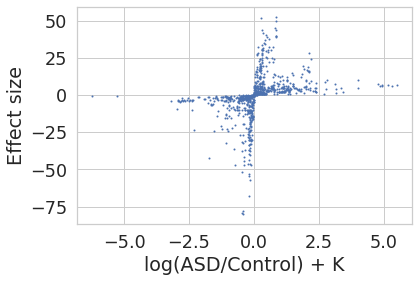

In [40]:
#amp_stats = ranking(amp_diffs, reference_percentile=50, log_probs=True)

plt.scatter(amp_stats['mean'], amp_stats['effect_size'], s=1)
plt.xlabel('log(ASD/Control) + K')
plt.ylabel('Effect size')

Text(0, 0.5, 'T-statistic')

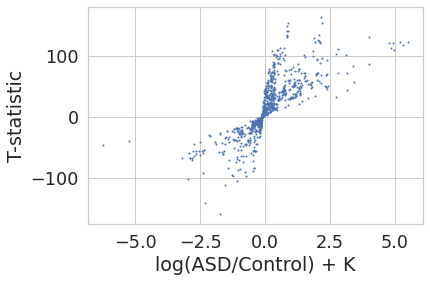

In [41]:
plt.scatter(amp_stats['mean'], amp_stats['tstat'], s=1)
plt.xlabel('log(ASD/Control) + K')
plt.ylabel('T-statistic')

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, '-log(pvalue)')

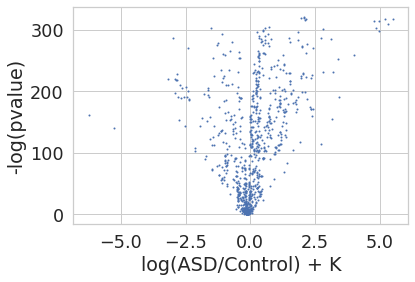

In [42]:
plt.scatter(amp_stats['mean'], -np.log10(amp_stats['pvalue']), s=1)
plt.xlabel('log(ASD/Control) + K')
plt.ylabel('-log(pvalue)')

Text(0, 0.5, 'log-odds ranking')

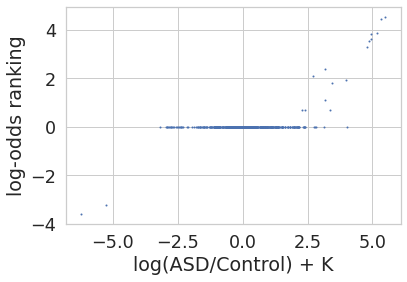

In [43]:
plt.scatter(amp_stats['mean'], amp_stats['prob_lr'], s=1)
plt.xlabel('log(ASD/Control) + K')
plt.ylabel('log-odds ranking')

In [44]:
ast.columns

Index(['mean', 'std', '5%', '50%', '95%', 'counts_bot', 'counts_top',
       'prob_top', 'prob_bot', 'prob_lr', 'effect_size', 'effect_std', 'tstat',
       'pvalue', 'cluster_id', 'cluster_name', 'Berding2020', 'Chen2020',
       'Dan2020', 'Fasano2020', 'Fouquier2021', 'Kang2017', 'Zou2020',
       'Zurita2019', 'num_studies', 'num_samples', 'GOTU', 'kingdom', 'phylum',
       'class', 'order', 'family', 'genus', 'species'],
      dtype='object')

# Alpha diversity

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Shannon diversity')

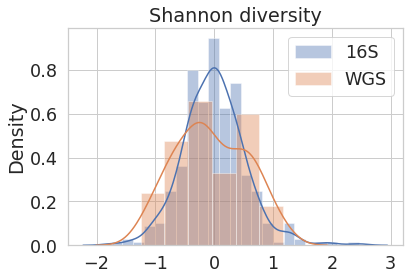

In [45]:
from scipy.stats import entropy
from skbio.stats.composition import closure
amp_div = pd.DataFrame(
    {
        'Shannon': entropy(closure(amp_table.values), axis=1), 
        'n_OTU': np.sum(amp_table > 0, axis=1),
    }, index=amp_table.index)

wgs_div = pd.DataFrame(
    {
        'Shannon': entropy(closure(wgs_table.values), axis=1), 
        'n_OTU': np.sum(wgs_table > 0, axis=1),
    }, index=wgs_table.index)

amp_md_div = pd.merge(amp_md_, amp_div, left_index=True, right_index=True)
wgs_md_div = pd.merge(wgs_md_, wgs_div, left_index=True, right_index=True)

amp_div_diff = amp_md_div.sort_values('Status')[['Match_IDs', 'Shannon']].groupby('Match_IDs').diff().dropna()
wgs_div_diff = wgs_md_div.sort_values('Status')[['Match_IDs', 'Shannon']].groupby('Match_IDs').diff().dropna()

sns.distplot(amp_div_diff, label='16S')
sns.distplot(wgs_div_diff, label='WGS')
plt.legend()
plt.title('Shannon diversity')

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, '# OTUs')

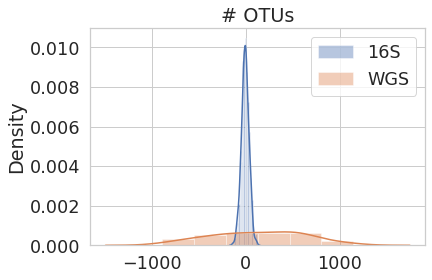

In [46]:
amp_div_diff = amp_md_div.sort_values('Status')[['Match_IDs', 'n_OTU']].groupby('Match_IDs').diff().dropna()
wgs_div_diff = wgs_md_div.sort_values('Status')[['Match_IDs', 'n_OTU']].groupby('Match_IDs').diff().dropna()

sns.distplot(amp_div_diff, label='16S')
sns.distplot(wgs_div_diff, label='WGS')
plt.legend()
plt.title('# OTUs')